In [2]:
import QuSatProtocol as qsp
import Security as sc
import GraphPlot as gp
import numpy as np
import os
from sys import exit

# List used to switch between False or True values
FT = [False, True]
# List used to switch between Fixed or Variable values
FV = ['Fixed', 'Variable']
# List of types of statistical bounds
BOPT = ['Chernoff','Hoeffding','Asymptotic']
# List of methods for estimating the number of error correction bits
ECOPT = ['logM','block','mXtot','None']
# List of methods for optimization of the SKL
from OptSet import OPT

#******************************************************************************
#******************************************************************************
#                      ---  USER INPUT SECTION  ---
#            Define the global parameters used in calculations
#******************************************************************************
#******************************************************************************

#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# Run a new mission for the following parameters or Load a previous saved
# misson:
#  > False (0): Load Misson
#  > True  (1): New Mission
New = FT[0]
Fixed_Sim = FT[1]
Opt_Param_Fixed = FT[1]

Mission = '1D' # Name of the mission

Load = FT[1]
Load_files = ['1D','2D','Fix1','Var1','Fixed_AS_opt']

#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

#******************************************************************************
#                              System Parameters
#******************************************************************************

states = 4                  # Number of secret key states
decoys = 1                  # Number of decoy states
h      = 500000             # Orbit altitude in [m]
dtrans = 0.04               # Transmitter aparture diameter in [m]
drece  = 0.7                # Receiver aparture diameter in [m]
waist  = dtrans/2           # Gaussian Beam Waist
wavel  = 1550 * 10**(-9)    # Wavelenght

#******************************************************************************
#                          Security Protocol Parameters
#******************************************************************************

# Variable Parameters that are optimised to give maximum SKL.
# var = [<initial value>,<Fixed or Variable>]:
#  > Fixed    (0)
#  > Variable (1)
pax = [ 0.6018 , FV[1] ]      # Alice's asymmetric basis choice probability
pbx = [ 0.8993 , FV[0] ]      # Bob's asymmetric basis choice probability
pk1 = [ 0.6390 , FV[0] ]      # Probability of preparing WCP intensity 1
pk2 = [ 0.2341 , FV[0] ]      # Probability of preparing WCP intensity 2
mu1 = [ 0.6977 , FV[0] ]      # WCP intensity 1
mu2 = [ 0.1251 , FV[0] ]      # WCP intensity 2
mu3 = 0.0                     # WCP intensity 3

# Optimisation ranges for each parameter.
# range_var = [<Lower bound>,<Upper bound>]
range_pax = [0.5 , 0.99]
range_pbx = [0.5 , 0.99]
range_pk1 = [0.6 , 0.99]
range_pk2 = [0.0005 , 0.4]
range_mu1 = [0.48 , 0.99]
range_mu2 = [0.005 , 0.45]

# Other Parameters
eps_c = 10**(-15)          # Correctness parameter
eps_s = 10**(-9)           # Secrecy parameter
QBERI = 5*10**(-3)           # Intrinsic Quantum Bit Error Rate (QBER_I)
pec   = 5*10**(-7)           # Extraneous count probability
pap   = 10**(-3)           # Afterpulse probability
srate = 1*10**(9)            # Repetition rate of the source in Hz

#******************************************************************************
#                        Advanced/additional Parameters
#******************************************************************************

# Define the value in dB for the intrinsic loss of the system
# (Detector efficiency, Optical efficiency)
intr = qsp.M_INT

# Select the type of tail bounds to use for estimating statistical fluctuations
# in the count statistics.
#  > Chernoff    (0)
#  > Hoeffding   (1)
#  > Asymptotic  (2)
boundM = BOPT[2]

# Select the method for estimating the number of bits sacrificed for error
# correction, listed below in order of decreasing precision (increasing
# smoothness).
#  > logM  = logM(nX, QBERx, eps_c)  (0)
#  > block = 1.16 * nX * h(QBERx)    (1)
#  > mXtot = 1.16 * mXtot            (2)
#  > None  = 0                       (3)
ECfunc = ECOPT[0]

# Select the methods for optimazing the SKL.
#  > COBYLA  (0)
#  > SLSQP   (1)
optM = OPT[1]
optP = { 'NoptMin':     10,      # Minimum No. of optimisations to strive for
         'NoptMax':     10000,  # Maximum No. of optimisations (not used)
         'Nmax':        1000,    # Max No. of iterations
         'tStopZero':   FT[1],  # Stop optimizing if the first NoptMin return SKL = 0?
         'tStopBetter': FT[1],  # Stop after NoptMin optimizations if SKL improved?
        }
if optM == 'COBYLA':
    # Optimiser options: minimize, method='COBYLA'
    optP['ctol']   = 1.0e-12    # Constraint absolute tolerance.
    optP['rhobeg'] = 0.002      # Reasonable initial changes to the variables.
else:
    # Optimiser options: minimize, method='SLSQP'
    optP['ftol'] = 1.0e-12      # Precision goal for the value of f in the stopping criterion.
    optP['eps']  = 1.0e-7       # Step size used for numerical approximation of the Jacobian.

#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

#******************************************************************************
#******************************************************************************
#                   ---  END OF USER INPUT SECTIONS  ---
#  ANY EDITS MADE BEYOND THIS POINT MAY AFFECT THE OPERATION OF THE SOFTWARE
#******************************************************************************
#******************************************************************************

#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

#**************************************************************************
# Verify and store all the parameters given by the user
#**************************************************************************
Param = qsp.Parameters()
# Store System Parameters
flag = []
flag += [ Param.States(states) ]
flag += [ Param.Decoys(decoys) ]
flag += [ Param.Alt(h) ]
flag += [ Param.DTransmitter(dtrans) ]
flag += [ Param.DReceiver(drece) ]
flag += [ Param.Waist(waist) ]
flag += [ Param.Wavelenght(wavel) ]
if -1 in flag:
    print('Error: On some system parameters:')
    if flag[0] == -1:
        print(' '*2 + '> States: {}'.format(states))
    elif flag[1] == -1:
        print(' '*2 + '> Decoys: {}'.format(decoys))
    elif flag[2] == -1:
        print(' '*2 + '> Altitude [h]: {}'.format(h))
    elif flag[3] == -1:
        print(' '*2 + '> Transmitter Diameter [dtrans]: {}'.format(dtrans))
    elif flag[4] == -1:
        print(' '*2 + '> Receiver Diameter [drece]: {}'.format(drece))
    elif flag[5] == -1:
        print(' '*2 + '> Beam Waist [waist]: {}'.format(waist))
    elif flag[6] == -1:
        print(' '*2 + '> Wavelenght [drece]: {}'.format(wavel))
    exit(1)

# Store Variable Parameters
flag=[]
if pax[1] == FV[0]: # Fixed
    flag += [ Param.PAx(pax[0]) ]
else:
    flag += [ Param.PAx(pax[0], range=range_pax) ]

if pbx[1] == FV[0]: # Fixed 
    flag += [ Param.PBx(pbx[0]) ]
else:
    flag += [ Param.PBx(pbx[0], range=range_pbx) ]

if pk1[1] == FV[0]: # Fixed
    flag += [ Param.PK1(pk1[0]) ]
else:
    flag += [ Param.PK1(pk1[0], range=range_pk1) ]

if pk2[1] == FV[0] or decoys == 1: # Fixed 
    flag += [ Param.PK2(pk2[0]) ]
else:
    flag += [ Param.PK2(pk2[0], range=range_pk2) ]

if mu1[1] == FV[0]: # Fixed 
    flag += [ Param.Mu1(mu1[0]) ]
else:
    flag += [ Param.Mu1(mu1[0], range=range_mu1) ]

if mu2[1] == FV[0]: # Fixed 
    flag += [ Param.Mu2(mu2[0]) ]
else:
    flag += [ Param.Mu2(mu2[0], range=range_mu2) ]

flag += [ Param.Mu3(mu3) ]


if -1 in flag:
    print('Error: On some Variable parameters:')
    if flag[0] == -1:
        print(' '*2 + '> PAx: {}:{} || {}'.format(pax[0],pax[1],range_pax))
    elif flag[1] == -1:
        print(' '*2 + '> PBx: {}:{} || {}'.format(pbx[0],pbx[1],range_pbx))
    elif flag[2] == -1:
        print(' '*2 + '> PK1: {}:{} || {}'.format(pk1[0],pk1[1],range_pk1))
    elif flag[3] == -1:
        print(' '*2 + '> PK2: {}:{} || {}'.format(pk2[0],pk2[1],range_pk2))
    elif flag[4] == -1:
        print(' '*2 + '> Mu1: {}:{} || {}'.format(mu1[0],mu1[1],range_mu1))
    elif flag[5] == -1:
        print(' '*2 + '> Mu2: {}:{} || {}'.format(mu2[0],mu2[1],range_mu2))
    elif flag[6] == -1:
        print(' '*2 + '> Mu3: {}:{} || {}'.format(mu3[0],mu3[1],0))
    exit(1)

# Store Protocol Parameters
flag = []
flag += [ Param.QBERI(QBERI) ]
flag += [ Param.Pap(pap) ]
flag += [ Param.Pec(pec) ]
flag += [ Param.SRate(srate) ]
flag += [ Param.Eps_s(eps_s) ]
flag += [ Param.Eps_c(eps_c) ]
if -1 in flag:
    print('Error: On some Protocol parameters:')
    if flag[0] == -1:
        print(' '*2 + '> QBERI: {}'.format(QBERI))
    elif flag[1] == -1:
        print(' '*2 + '> Pap: {}'.format(pap))
    elif flag[2] == -1:
        print(' '*2 + '> Pec: {}'.format(pec))
    elif flag[3] == -1:
        print(' '*2 + '> Source Rate: {}'.format(srate))
    elif flag[4] == -1:
        print(' '*2 + '> Eps_s: {}'.format(eps_s))
    elif flag[5] == -1:
        print(' '*2 + '> Eps_c: {}'.format(eps_c))
    exit(1)

# Store Advanced/additional Parameters
flag = []
flag += [ Param.Intr(intr) ]
flag += [ Param.BoundM(boundM) ]
flag += [ Param.ECfunc(ECfunc) ]
flag += [ Param.OptM(optM) ]
flag += [ Param.OptP(optP) ]
if -1 in flag:
    print('Error: On some Protocol parameters:')
    if flag[0] == -1:
        print(' '*2 + '> Intrinsinc: {}'.format(intr))
    elif flag[1] == -1:
        print(' '*2 + '> Bound Method: {}'.format(boundM))
    elif flag[2] == -1:
        print(' '*2 + '> Error Correction Function: {}'.format(ECfunc))
    elif flag[3] == -1:
        print(' '*2 + '> Optimization Method: {}'.format(optM))
    elif flag[4] == -1:
        print(' '*2 + '> Optimization Parameter: {}'.format(optP))
    exit(1)

#**************************************************************************
# Run Simulation
#**************************************************************************
if New:
    SParam, PParam, AdvParam = Param.get()
    if Fixed_Sim:
        if Opt_Param_Fixed:
            qsp.Fixed_Sim(SParam, PParam, AdvParam, Print=True, outfile=Mission, opt=True)
        else:
            qsp.Fixed_Sim(SParam, PParam, AdvParam, Print=True, outfile=Mission)        
    else:
        qsp.Pass_Sim(SParam, PParam, AdvParam, Print=True, outfile=Mission)

#**************************************************************************
# Load Simulation Data
#**************************************************************************

# SysLoss [0], DiffLoss [1], AtmLoss [2], IntrLoss [3], time [4], dt [5], elev [6], SKL [7],
# QBERx [8], phiX [9], nX [10], nZ [11], mX [12], lambdaEC [13], sX0 [14], sX1 [15],vZ1 [16],
# sZ1 [17], mean photon no. [18], D1 [19], D2 [20], D3 [21], e1 [22], e2 [23], e3 [24], 
# QBERI [25], Pec [26], Pap [27], Rrate [28], eps_c [29], eps_s [30], 
# PAx [31], PBx [32], P1 [33], P2 [34], P3 [35], mu1 [36], mu2 [37], mu3 [38]

if Load:
    Dd = os.path.join(os.getcwd(),'Data','RawData')
    Raw_Data = []
    for name in Load_files:
        Raw_Data += [qsp.loadData(Dd,name + '.csv')]
    
    t    = []           # Time [s]
    dt   = []           # Time window (delta) [s]
    elev = []           # Elevation [rad]
    loss = []           # Loss [dB]
    diff = []           # Diffraction Loss [dB]
    atm  = []           # Atmospheric Loss [dB]
    intr = []           # Intrinsic Loss [dB]
    SKL  = []           # Secret Key Lenght [bits]
    QBER = []           # Quantum Bit Error Rate [%]
    phiX = []           # Error Phase
    D1   = []           # Detection Probability Intensity 1
    D2   = []           # Detection Probability Intensity 2
    D3   = []           # Detection Probability Intensity 3

    for data in Raw_Data:
        loss += [data[:,0]]
        diff += [data[:,1]]
        atm  += [data[:,2]]
        intr += [data[:,3]]
        t    += [data[:,4]]
        dt   += [data[:,5]]
        elev += [data[:,6]]

        SKL  += [data[:,7]]
        QBER += [data[:,8]]
        phiX += [data[:,9]]

        D1   += [data[:,19]]
        D2   += [data[:,20]]
        D3   += [data[:,21]]
    

In [8]:
order_P1 = ['SKL','QBERx','phi_x','nX','nZ','mX','lambdaEC','sx0','sx1','vz1','sz1','mpn']
order_P2 = ['D1','D2','D3','e1','e2','e3']
order_P3 = ['Pax','Pbx','Pk1','Pk2','Pk3','mu1','mu2','mu3']

print('_'*60,'\n')
m = 1
t0 = int(len(t[m])/2) - 1

print('Mission {}: Values for t = {} s || Loss = {:.2f} dB '.format(Load_files[m],t[m][t0],loss[m][t0]))
print('Loss Model [dB]: > Diff: {:.02f}  '.format(diff[m][t0]) + \
      ' > Atm: {:.02f}  '.format(atm[m][t0]) + \
      ' > Intr: {:.02f}'.format(intr[m][t0]))
print('-'*60)
print('  >  SKR: {:.02f} kbps'.format(SKL[m][t0]/dt[m][t0] *10**-3))
print('_'*60)



____________________________________________________________ 

Mission 2D: Values for t = 0.0 s || Loss = 27.03 dB 
Loss Model [dB]: > Diff: 24.95   > Atm: 12.78   > Intr: 5.30
------------------------------------------------------------
  >  SKR: 242.16 kbps
____________________________________________________________


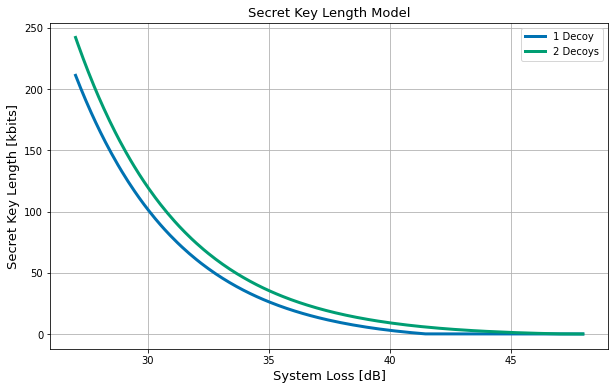

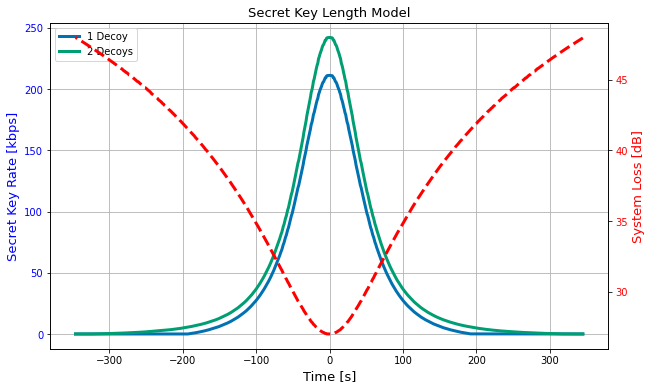

In [9]:
plt = gp.plot()
plt.default_settings.Grid(True)

loss_axis = loss[0][:t0]

plt.add_data(loss_axis,[n/1000 for n in SKL[0][:t0]],'1 Decoy')
plt.add_data(loss_axis,[n/1000 for n in SKL[1][:t0]],'2 Decoys')
plt.title("Secret Key Length Model")
plt.y_legend("Secret Key Length [kbits]")
plt.x_legend("System Loss [dB]")
plt.plot()

plt.pop_all()
plt.add_data(t[0], [SKL[0][n]*10**(-3)/dt[0][n] for n in range(len(SKL[0]))],'1 Decoy')
plt.add_data(t[1], [SKL[1][n]*10**(-3)/dt[1][n] for n in range(len(SKL[1]))],'2 Decoys')
plt.add_twindata(t[0],loss[0],style='r--')
plt.x_legend("Time [s]")
plt.y_legend("Secret Key Rate [kbps]")
plt.ytwin_legend("System Loss [dB]")
plt.twinplot(scale=None)



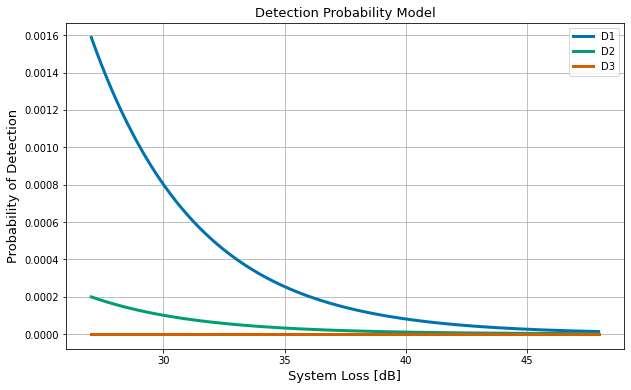

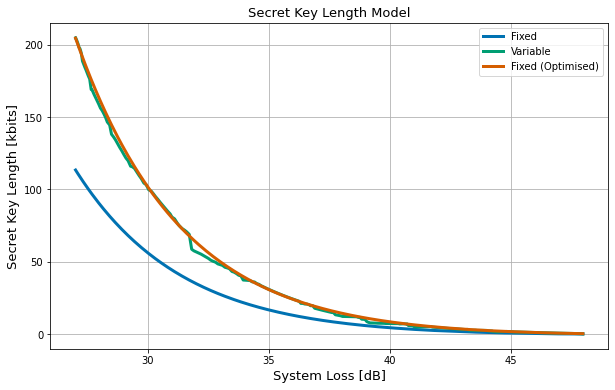

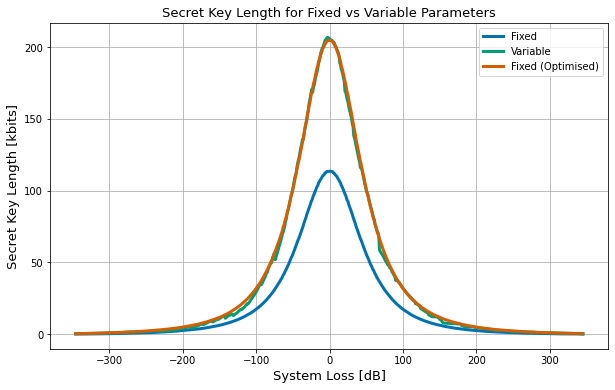

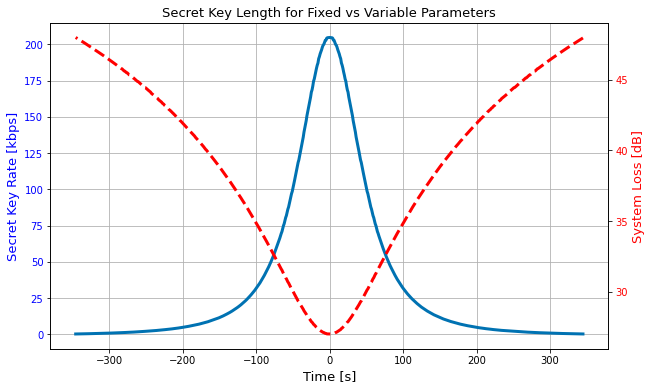

In [10]:
plt = gp.plot()
plt.default_settings.Grid(True)

t0 = int(len(t[0])/2) - 1
loss_axis = loss[0][:t0]

plt.add_data(loss_axis,D1[2][:t0],label='D1')
plt.add_data(loss_axis,D2[2][:t0],label='D2')
plt.add_data(loss_axis,D3[2][:t0],label='D3')
plt.title("Detection Probability Model")
plt.y_legend("Probability of Detection")
plt.x_legend("System Loss [dB]")
plt.plot()

plt.pop_all()
plt.add_data(loss_axis,[n/1000 for n in SKL[2][:t0]],label='Fixed')
plt.add_data(loss_axis,[n/1000 for n in SKL[3][:t0]],label='Variable')
plt.add_data(loss_axis,[n/1000 for n in SKL[4][:t0]],label='Fixed (Optimised)')
plt.title("Secret Key Length Model")
plt.y_legend("Secret Key Length [kbits]")
plt.x_legend("System Loss [dB]")
plt.plot()

plt.pop_all()
plt.add_data(t[2],[SKL[2][n]*10**(-3)/dt[2][n] for n in range(len(SKL[2]))],label='Fixed')
plt.add_data(t[3],[SKL[3][n]*10**(-3)/dt[3][n] for n in range(len(SKL[3]))],label='Variable')
plt.add_data(t[4],[SKL[4][n]*10**(-3)/dt[4][n] for n in range(len(SKL[4]))],label='Fixed (Optimised)')
plt.title("Secret Key Length for Fixed vs Variable Parameters")
plt.y_legend("Secret Key Length [kbits]")
plt.x_legend("System Loss [dB]")
plt.plot()

plt.pop_all()
plt.add_data(t[4], [SKL[4][n]*10**(-3)/dt[4][n] for n in range(len(SKL[4]))])
plt.add_twindata(t[4],loss[4],style='r--')
plt.x_legend("Time [s]")
plt.y_legend("Secret Key Rate [kbps]")
plt.ytwin_legend("System Loss [dB]")
plt.twinplot(scale=None)

